<h1><center>HW1 Movie Review Sentiment Analysis</center></h1>

In this homework you will create different models to generate the positive/negative sentiment
classification of movie reviews. Note that in our homework we will be using Python 3. So when you install Anaconda make sure to choose Python 3 (and maybe use a virtual environment if that's easier).

This homework should be done individually without cooperation with others.

You are given the following files:
- `hw01.ipynb`: Notebook file with starter code
- `train.txt`: Training set to train your model
- `test.txt`: Test set to report your model’s performance
- `sample_prediction.csv`: Sample file your prediction result should look like
- `utils/`: folder containing all utility code for the series of homeworks

Remember to leverage code in `utils/`, so you don't have to build everything from
Scratch.
- `load_data(filename)`: load the input data and return sklearn.Bunch object. For basic
usage of Bunch object, please refer to sklearn documentation.
- `save_prediction(arr, filename)`: save your prediction into the format required by the
course

<h3> 0. Install Anaconda </h3>

If you do not yet have Python and Jupyter Notebook on your laptop, use this link
(https://www.anaconda.com/) to install anaconda. Anaconda is a suite that provides one
stop solution for all you need for Python development environment. This site contains
installation document for Windows, Mac, and Linux, choose the one that suits your operating
system.

*Tips: You may want to consider installing Jupyter Extensions (link: https://github.com/ipython-contrib/jupyter_contrib_nbextensions), and turn on extensions such as `ExcuteTime` and 
`Table of Contents(2)`. You may find them very helpful to assist you finishing homework. However, this 
is definitely not a necessary requirement.*

<h3> 1. Feature Dictionary Vectorization </h3> 

A quite unique step for NLP is to engineer the raw text input into numerical features. You will
eventually implement several featurizers, just like `dummy_featurize`, that distinguish your
models with others. However, we are not there yet. For convenience we allow you to
represent the features using a dictionary, look at the `dummy_featurize` code. So each data
point can be translated into a dictionary. However later we have to translate this list of
dictionaries into a homogeneous data structure. Therefore, you need to first implement the
pipeline method in the `SentimetnClassifier` class. Look into the code comment for more
details. To ensure your implementation works, we also provided some test code in the cell
below.

<h3> 2. Better featurizers </h3>

Have you finished the first step, you can run the model using the provided featurizer. See
the performance is nearly as good as a donkey? No surprise! The `dummy_featurize` should
have been named `really_dummy_featurize`. Now it is your turn to implement better
featurizers. For this homework, you need to implement at least 3 distinguishable featurizer.
Describe your features briefly in the write-up and include the accuracy of the model. No idea
at all? Look at your lecture notes for inspiration. Still no clue? Why not start with Bag of
words?

*Note: Model performance is important but it’s not the only thing we care about, your work will
also be rewarded by your creativity.*

<h3> 3. Optional: Try different learning methods </h3> 

All the work you have done so far are related to feature engineering, and the featurized data
is trained using Logistic Regression. Try to use different learning methods to train the model
and see if you achieve any difference in the performance. Discuss your findings in the
write-up.

<h3> 4. Deliverables (zip them all) </h3>

- pdf version of your final notebook
- Use the best model you trained, generate the prediction for test.txt, name the
output file prediction.csv (Be careful: the best model in your training set might not
be the best model for the test set).
- HW1_writeup.pdf: summarize the method you used and report their performance.
If you worked on the optional task, add the discussion. Add a short essay
discussing the biggest challenges you encounter during this assignment and
what you have learnt.

(**You are encouraged to add the writeup doc into your notebook
using markdown/html langauge, just like how this notes is prepared**)


# =============== Coding Starts Here ===================

In [204]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path
    
from utils.hw1 import load_data, save_prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Featurizer

In [2]:
"""
!! Do not modify !!
"""
def dumb_featurize(text):
    feats = {}
    words = text.split(" ")

    for word in words:
        if word == "love" or word == "like" or word == "best":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike" or word == "worst" or word == "awful":
            feats["contains_negative_word"] = 1

    return feats

In [240]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download, data

In [238]:
def preprocess_text(text: str, lmtzr=None, verbose=False):
    """Preprocess text data: remove symbols, stop words, and apply tokenization and lemmatization"""
    if verbose:
        print('='*80)
        print('Preprocess Text Data')
    text = text.strip()
    
    # remove symbols
    text = re.sub("[^A-Za-z0-9' ]+", ' ', text.lower())
    
    # tokenization
    if verbose:
        print('_'*80)
        print('Tokenization')
    try:
        data.find('tokenizers/punkt')
    except LookupError:
        print('downloading tokenizers/punkt.zig from nltk')
        download('punkt')
    text = word_tokenize(text)

    # remove stopwords
    if verbose:
        print('_' * 80)
        print('Remove stopwords')
    try:
        data.find('corpora/stopwords.zip')
    except LookupError:
        print('downloading corpora/stopwords.zig from nltk')
        download('stopwords')
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]

    # lemmatization
    if verbose:
        print('_' * 80)
        print('Lemmatization')
    if not lmtzr:
        try:
            data.find('corpora/wordnet.zip')
        except LookupError:
            print('downloading corpora/wordnet.zig from nltk')
            download('wordnet')
        lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    return text


def better_featurize(text):
#     raise NotImplementedError
    """
    !! Do not work on this yet, work on the model and come back later !!
    
    Write your own code below
    """
    return Counter(preprocess_text(text))

## Model Class

In [246]:
from collections import Counter
from scipy.sparse import dok_matrix
from sklearn.linear_model import LogisticRegression

class SentimentClassifier:
    def __init__(self, feature_method=dumb_featurize, min_feature_ct=1, L2_reg=1.0, max_feature_ct=None):
        """
        :param feature_method: featurize function
        :param min_feature_count: int, ignore the features that appear less than this number to avoid overfitting
        """
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_ct = min_feature_ct
        if not max_feature_ct:
            self.max_feature_ct = float('inf')
        else:
            self.max_feature_ct = max_feature_ct
        self.L2_reg = L2_reg

    def featurize(self, X):
        """
        # Featurize input text

        :param X: list of texts
        :return: list of featurized vectors
        """
        featurized_data = list(map(self.feature_method, X))
        return featurized_data
    
    def _build_vocab(self, X):
        """
        Build internal vocabulary {'feature': [index, count]}
        :param X: featurized input
        """
        # build counter for whole corpus
        t1 = time()
        self.c = Counter()
        for dic in X:
            self.c.update(dic)
        # build vocabulary by iterating through the counter
        idx = 0
        for fea, cnt in self.c.items():            
            if fea not in self.feature_vocab and self.max_feature_ct >= cnt >= self.min_feature_ct:
                self.feature_vocab[fea] = idx
                idx += 1
        # add key for unknown words
        self.feature_vocab['__UNKNOWN__'] = idx
        t2 = time()
        elp = t2 - t1
        print(f'learned new vocabulary! # of words = {len(self.feature_vocab)}(including 1 UNKNOWN word), took {round(elp, 5)} seconds')
        
    def _parse_featurized(self, X, normalize):
        """
        Parse featurized data into sparse matrix
        :param X: featureized input
        :return tf: sparse matrix
        """
        assert len(self.feature_vocab) > 0, 'vocabulary is not learned yet, try self.pipeline(X, training=True)'
        tf = dok_matrix((len(X), len(self.feature_vocab)), dtype=np.float32)
        for i, x in enumerate(X):
            for fea, cnt in x.items():
                if fea in self.feature_vocab:
                    tf[i, self.feature_vocab[fea]] = cnt
                else:
                    tf[i, -1] = cnt
                

        df = np.sign(tf.toarray()).sum(0) / tf.get_shape()[0]
        self.idf = np.log(1/(df+1)) + 1  # add 1 to document frequency to avoid zero division
        tfidf = tf.multiply(self.idf)
        # nomarlize each row to have unit norm
        if normalize:
            dense_sq = tfidf.toarray()**2
            row_sq_sum = dense_sq.sum(1)
            tfidf = dok_matrix(np.sqrt(dense_sq / row_sq_sum[:, None]))
        return tfidf

    def pipeline(self, X, training=False, normalize=False):
        """
        Data processing pipeline to translate raw data input into sparse vectors
        :param X: featurized input
        :return X2: 2d sparse vectors
        
        Implement the pipeline method that translate the dictionary like feature vectors into 
        homogeneous numerical vectors, for example:
        [{"fea1": 1, "fea2": 2}, 
         {"fea2": 2, "fea3": 3}] 
         --> 
         [[1, 2, 0], 
          [0, 2, 3]]
          
        Hints:
        1. How can you know the length of the feature vector?
        2. When should you use sparse matrix?
        3. Have you treated non-seen features properly?
        4. Should you treat training and testing data differently?
        """
        # Have to build feature_vocab during training
        if training:
            self._build_vocab(X)
         
        # Translate raw texts into vectors
        X2 = self._parse_featurized(X, normalize)

        return X2

    def fit(self, X, y, standardize=True, normalize=False, **kwargs):
#         pdb.set_trace()
        X = self.pipeline(self.featurize(X), training=True, normalize=normalize)

        D, F = X.shape
        if standardize:
            self.scaler = StandardScaler(with_mean=False)
            X = self.scaler.fit_transform(X)
        else:
            self.scaler = None
        # fit training data
        self.model = LogisticRegression(C=self.L2_reg, **kwargs)
        self.model.fit(X, y)

        return self

    def predict(self, X, normalize=False):
        X = self.pipeline(self.featurize(X), normalize=normalize)
        if self.scaler:
            X = self.scaler.transform(X)
        return self.model.predict(X)

    def score(self, X, y, normalize=False):
        X = self.pipeline(self.featurize(X), normalize=normalize)
        if self.scaler:
            X = self.scaler.transform(X)
        return self.model.score(X, y)

    # Write learned parameters to file
    def save_weights(self, filename='weights.csv'):
        weights = [["__intercept__", self.model.intercept_[0]]]
        for feat, idx in self.feature_vocab.items():
            weights.append([feat, self.model.coef_[0][idx]])
        
        weights = pd.DataFrame(weights)
        weights.to_csv(filename, header=False, index=False)
        
        return weights

In [ ]:
def plot_train_test(cv_results, mode='accuracy', logscale=True, ax=None, figsize=(10, 5), title=''):
    assert mode in ('train_time', 'accuracy')
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    df = cv_results[['mean_fit_time', 'param_C', 'param_penalty']].copy()
    if logscale:
        if df['param_C'].dtype == 'O':
            df.loc[:, 'param_C'] = df['param_C'].astype('float')
        df.loc[:, 'param_C'] = np.log10(df['param_C'])
    # convert cv results into long form
    df = df.join(cv_results[['mean_train_score', 'mean_test_score']].rename(columns={'mean_train_score': 'train', 'mean_test_score': 'validation'}).unstack().reset_index().set_index('level_1').rename(columns={'level_0': '', 0: 'accuracy'}))
    if mode == 'accuracy':
        var = 'accuracy'
    else:
        var = 'mean_fit_time'
    _ = sns.lineplot(data=df, x="param_C", y=var, hue="", style="param_penalty", ax=ax, markers=True, dashes=True)
    _ = ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    _ = ax.set_title(f'{title} {var}')

In [222]:
"""
Run this to test your model implementation
"""

cls = SentimentClassifier()
X_train = [{"fea1": 1, "fea2": 2}, {"fea2": 2, "fea3": 3}]

X = cls.pipeline(X_train, True)
assert X.shape[0] == 2 and X.shape[1] >= 3, "Fail to vectorize training features"

X_test = [{"fea1": 1, "fea2": 2}, {"fea2": 2, "fea3": 3}]
X = cls.pipeline(X_test)
assert X.shape[0] == 2 and X.shape[1] >= 3, "Fail to vectorize testing features"

X_test = [{"fea1": 1, "fea2": 2}, {"fea2": 2, "fea4": 3}]
try:
    X = cls.pipeline(X_test)
    assert X.shape[0] == 2 and X.shape[1] >= 3
except:
    raise Exception("Fail to treat un-seen features")
    
print("Success!!")

learned new vocabulary! # of words = 4(including 1 UNKNOWN word), took 3e-05 seconds
Success!!


## Run your model

In [227]:
import pdb

In [233]:
"""
Run this cell to test your model
"""
from sklearn.model_selection import train_test_split

text_data = load_data("train.txt")
X, y = text_data.text, text_data.target
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=42)
cls = SentimentClassifier(feature_method=dumb_featurize)
cls = cls.fit(X_train, y_train, standardize=False)
print("Training set accuracy: ", cls.score(X_train, y_train))
print("Dev set accuracy: ", cls.score(X_dev, y_dev))

learned new vocabulary! # of words = 3(including 1 UNKNOWN word), took 0.00845 seconds
Training set accuracy:  0.5248571428571429
Dev set accuracy:  0.5203333333333333


##  Example of better featurizer

In [234]:
def bag_of_words(text):
    # do stuff here
    return Counter(text)

In [245]:
text_data = load_data("train.txt")
X, y = text_data.text, text_data.target
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3)
cls = SentimentClassifier(feature_method=better_featurize, min_feature_ct=10)
cls = cls.fit(X_train, y_train, standardize=True, normalize=True, solver='saga', tol=1e-5, max_iter=1e5)
print("Training set accuracy: ", cls.score(X_train, y_train))
print("Dev set accuracy: ", cls.score(X_dev, y_dev))

learned new vocabulary! # of words = 6644(including 1 UNKNOWN word), took 0.16351 seconds
1
Training set accuracy:  0.9995714285714286
Dev set accuracy:  0.696


### Fine tune hyperparam

In [42]:
# Use all train data for cross validation

X_train = cls.pipeline(cls.featurize(text_data.text), training=True)
y_train = text_data.target

learned new vocabulary! # of words = 8430(including 1 UNKNOWN word), took 0.22068 seconds


#### tune C&penalty type

- C: np.loagspace(-3, 3, 10), penalty: ['l1', 'l2']

In [ ]:
grid = {'C': np.logspace(-3, 3, 10),
        'penalty': ['l2', 'l1']}

In [177]:
clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)

In [178]:
scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler.fit_transform(X_train)

In [179]:
cv.fit(X_tr, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0, solver='saga',
                                          tol=1e-05),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [180]:
results = pd.DataFrame(cv.cv_results_)
results.to_csv('cv.csv')

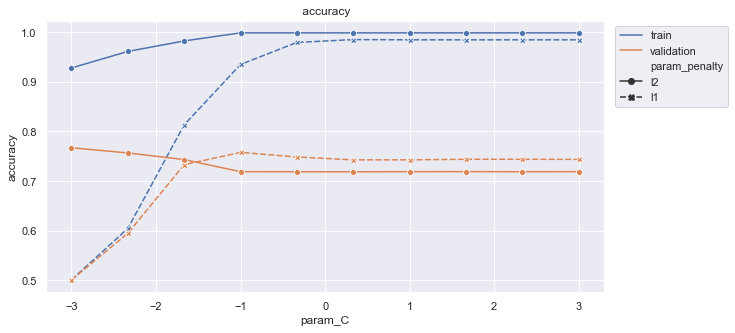

In [65]:
plot_train_test(results, mode='accuracy')

- C: np.loagspace(-3, 0, 10), penalty: ['l1', 'l2']

In [45]:
grid = {'C': np.logspace(-3, 0, 10),
        'penalty': ['l2', 'l1']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)

scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler.fit_transform(X_train)

cv.fit(X_tr, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0, solver='saga',
                                          tol=1e-05),
             n_jobs=-1,
             param_grid={'C': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [46]:
res = pd.DataFrame(cv.cv_results_)

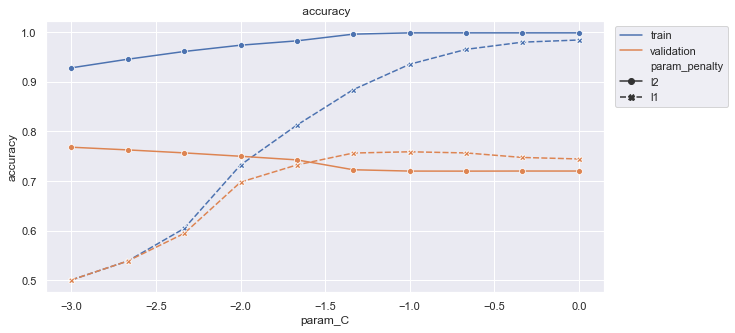

In [83]:
plot_train_test(res, mode='accuracy', logscale=True)

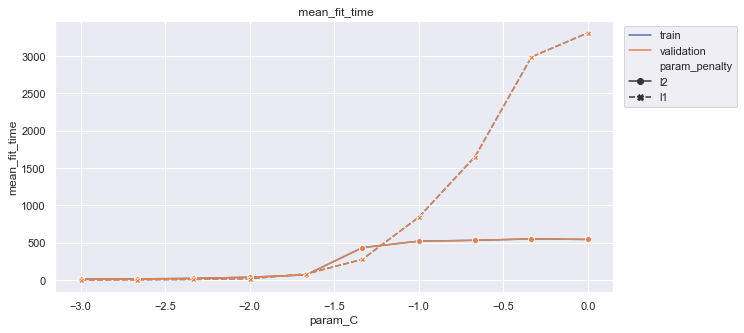

In [84]:
plot_train_test(res2, mode='train_time', logscale=True)

- C: np.loagspace(-5, -0.5, 10), penalty: ['l1', 'l2']

In [54]:
grid = {'C': np.logspace(-5, -0.3, 10),
        'penalty': ['l2', 'l1']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)

scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler.fit_transform(X_train)

cv.fit(X_tr, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0, solver='saga',
                                          tol=1e-05),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.32829814e-05, 1.10775685e-04, 3.68694506e-04,
       1.22712524e-03, 4.08423865e-03, 1.35935639e-02, 4.52434335e-02,
       1.50583635e-01, 5.01187234e-01]),
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [55]:
res3 = pd.DataFrame(cv.cv_results_)

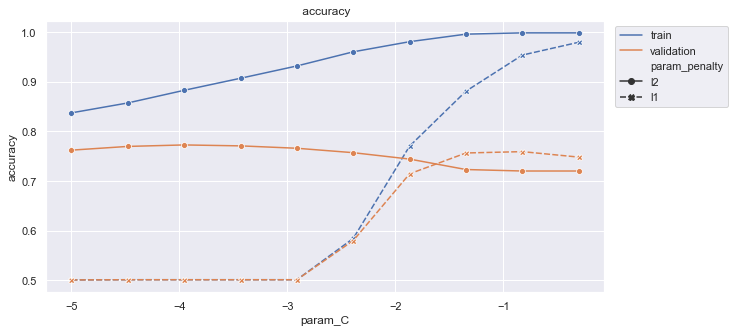

In [85]:
plot_train_test(res3, mode='accuracy', logscale=True)

#### try different min_feature_ct

- min_feature = 20

In [ ]:
# Use all train data for cross validation
cls2 = SentimentClassifier(feature_method=better_featurize, min_feature_ct=20)

X_train = cls2.pipeline(cls.featurize(text_data.text), training=True)
y_train = text_data.target

scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler.fit_transform(X_train)

In [93]:
grid = {'C': np.logspace(-5, -2, 20),
        'penalty': ['l2', 'l1']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)


cv.fit(X_tr, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0, solver='saga',
                                          tol=1e-05),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.43844989e-05, 2.06913808e-05, 2.97635144e-05,
       4.28133240e-05, 6.15848211e-05, 8.85866790e-05, 1.27427499e-04,
       1.83298071e-04, 2.63665090e-04, 3.79269019e-04, 5.45559478e-04,
       7.84759970e-04, 1.12883789e-03, 1.62377674e-03, 2.33572147e-03,
       3.35981829e-03, 4.83293024e-03, 6.95192796e-03, 1.00000000e-02]),
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy', verbose=10)

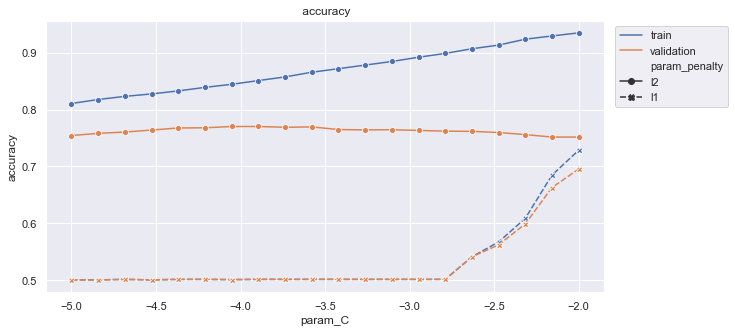

In [94]:
res = pd.DataFrame(cv.cv_results_)

plot_train_test(res, mode='accuracy', logscale=True)

- min_feature = 30

In [109]:
# Use all train data for cross validation
cls = SentimentClassifier(feature_method=better_featurize, min_feature_ct=30)

X_train = cls3.pipeline(cls.featurize(text_data.text), training=True)
y_train = text_data.target

scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler3.fit_transform(X_train)

learned new vocabulary! # of words = 3664(including 1 UNKNOWN word), took 0.19918 seconds


In [97]:
grid = {'C': np.logspace(-5, -2, 20),
        'penalty': ['l2', 'l1']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)


cv.fit(X_tr, y_train3)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0, solver='saga',
                                          tol=1e-05),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.43844989e-05, 2.06913808e-05, 2.97635144e-05,
       4.28133240e-05, 6.15848211e-05, 8.85866790e-05, 1.27427499e-04,
       1.83298071e-04, 2.63665090e-04, 3.79269019e-04, 5.45559478e-04,
       7.84759970e-04, 1.12883789e-03, 1.62377674e-03, 2.33572147e-03,
       3.35981829e-03, 4.83293024e-03, 6.95192796e-03, 1.00000000e-02]),
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='accuracy', verbose=10)

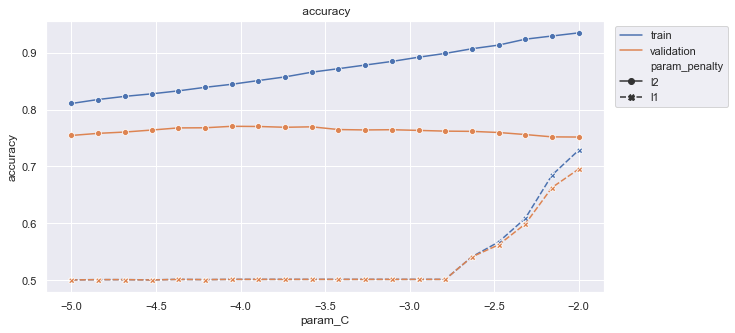

In [98]:
res = pd.DataFrame(cv.cv_results_)

plot_train_test(res, mode='accuracy', logscale=True)

### max_feature_ct

- max_feature_ct = 1000

In [129]:
# Use all train data for cross validation
cls = SentimentClassifier(feature_method=better_featurize, min_feature_ct=20, max_feature_ct=1000)

X_train = cls.pipeline(cls.featurize(text_data.text), training=True)
y_train = text_data.target

learned new vocabulary! # of words = 5025(including 1 UNKNOWN word), took 0.20998 seconds


Fitting 5 folds for each of 40 candidates, totalling 200 fits


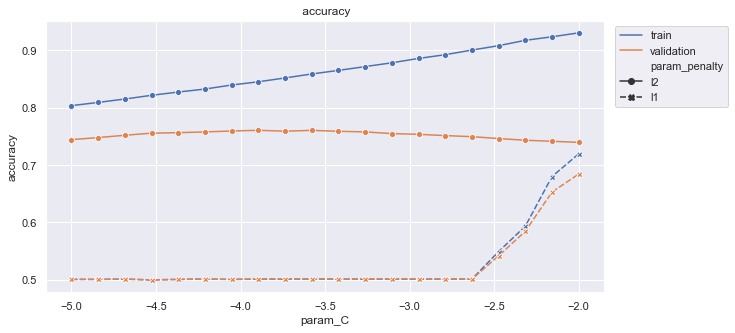

In [130]:
scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler3.fit_transform(X_train)

grid = {'C': np.logspace(-5, -2, 20),
        'penalty': ['l2', 'l1']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)


cv.fit(X_tr, y_train)

res = pd.DataFrame(cv.cv_results_)

plot_train_test(res, mode='accuracy', logscale=True)

- max_feature_ct = 500

In [202]:
# Use all train data for cross validation
cls = SentimentClassifier(feature_method=better_featurize, min_feature_ct=20, max_feature_ct=500)

X_train = cls.pipeline(cls.featurize(text_data.text), training=True)
y_train = text_data.target

learned new vocabulary! # of words = 4907(including 1 UNKNOWN word), took 0.22094 seconds


Fitting 5 folds for each of 20 candidates, totalling 100 fits


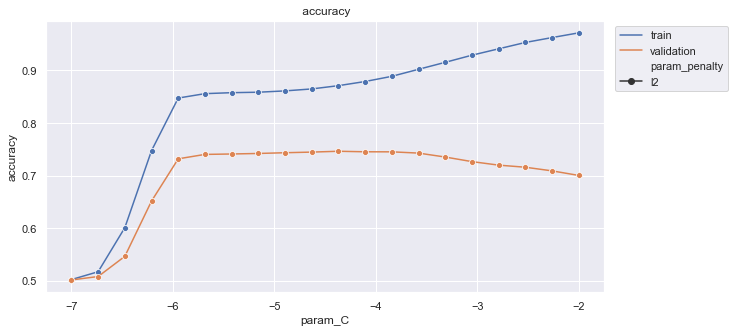

In [206]:
scaler = StandardScaler(with_mean=False)

# fit training data
X_tr = scaler.fit_transform(X_train)

grid = {'C': np.logspace(-7, -2, 20),
        'penalty': ['l2']}

clf = LogisticRegression(tol=1e-5, max_iter=1e5, solver='saga')
cv = GridSearchCV(clf, grid, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=10, return_train_score=True)


cv.fit(X_tr, y_train)

res = pd.DataFrame(cv.cv_results_)

plot_train_test(res, mode='accuracy', logscale=True)

In [207]:
cv.best_score_

0.7462

In [209]:
cv.best_params_

{'C': 4.281332398719396e-05, 'penalty': 'l2'}

### Retrain the model with optimal param

In [247]:
cls = SentimentClassifier(feature_method=better_featurize, min_feature_ct=20, max_feature_ct=500, L2_reg=cv.best_params_['C'])
cls = cls.fit(text_data.text, text_data.target, standardize=True, normalize=True, solver='saga', tol=1e-5, max_iter=1e5)

learned new vocabulary! # of words = 4907(including 1 UNKNOWN word), took 0.23867 seconds


In [248]:
print("Training set accuracy: ", cls.score(text_data.text, text_data.target))

Training set accuracy:  0.8606


In [249]:
"""
Run this cell to save weights and the prediction
"""
weights = cls.save_weights()

X_test = load_data("test.txt").text
save_prediction(cls.predict(X_test))